In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets, Layout, HBox, VBox
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator


%matplotlib inline



In [196]:
data = pd.read_csv("UEC.csv", index_col=0)

In [197]:
data['Mid_Price'] = (data['Bids'] + data['Asks']) / 2
data['Spread'] = data['Asks'] - data['Bids']


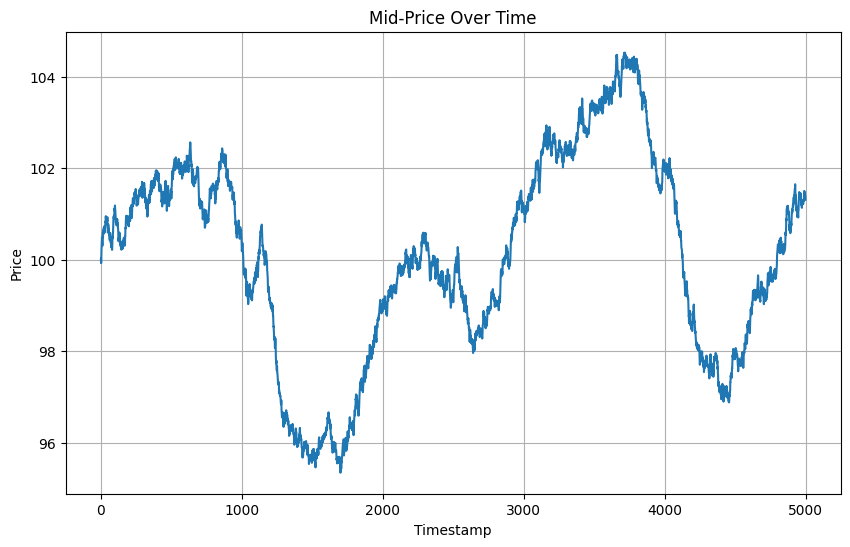

In [198]:
# Plot mid-price
plt.figure(figsize=(10, 6))
plt.plot(data['Mid_Price'])
plt.title('Mid-Price Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.grid(True)
plt.show()

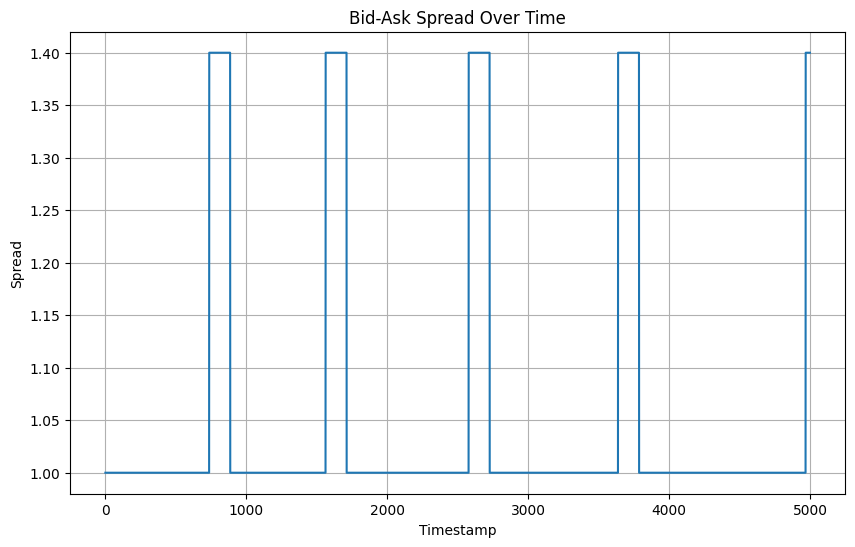

In [199]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Spread'])
plt.title('Bid-Ask Spread Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Spread')
plt.grid(True)
plt.show()


Successfully loaded data with 50000 rows

Data sample:
        Bids        Asks
0  99.500000  100.500000
1  99.537317  100.537317
2  99.424572  100.424572
3  99.568641  100.568641
4  99.718064  100.718064


/var/folders/dg/gndvkfz564g235vdv95241jw0000gn/T/ipykernel_88830/1925787078.py:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  high_spread_shifted = result['In_High_Spread'].shift(1).fillna(False)


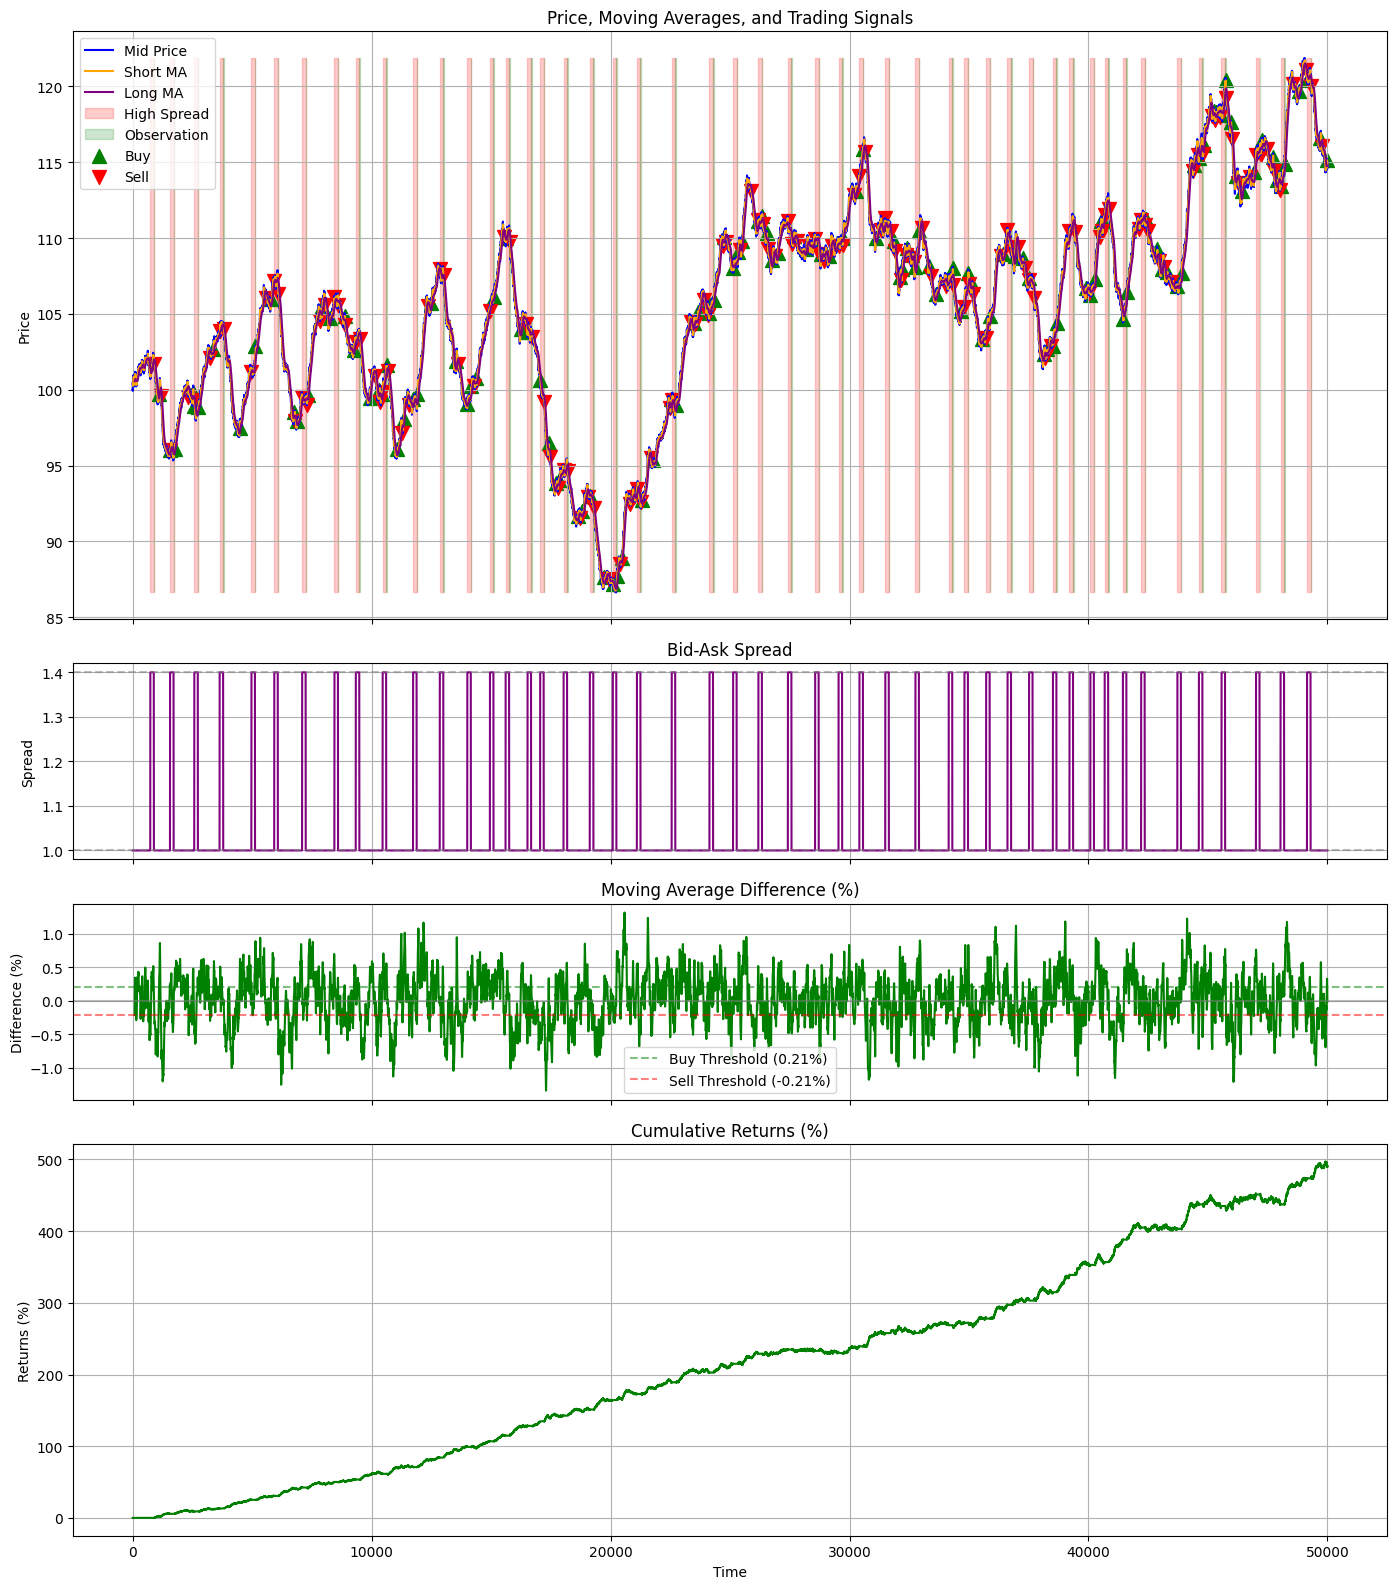

=== Strategy Performance ===
Total Return: 490.66%
Sharpe Ratio: 12.57
Max Drawdown: -3.85%
Win Rate: 60.14% (86/143)
Total Trades: 275
Average Win: 1.80%
Average Loss: -0.55%
Profit Factor: 4.92


In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def spread_ma_strategy(data, 
                       high_spread_threshold=1.3,  # Threshold for identifying high spread
                       low_spread_threshold=1.1,   # Threshold for identifying low spread
                       short_ma_window=20,         # Short moving average window
                       long_ma_window=70,          # Long moving average window
                       observation_window=30,      # Observation window after exiting high spread
                       ma_crossover_threshold=0.3, # Threshold for MA crossover signal (%)
                       plot_results=True           # Whether to plot results
                      ):
    """
    Implements a simple spread and moving average trading strategy:
    
    1. Wait for first high spread period before generating any signals
    2. After exiting high spread, wait for observation window to complete
    3. In low spread periods, take long/short positions based on moving average crossovers
    4. Close all positions when entering high spread periods
    
    Parameters
    ----------
    data : pandas DataFrame
        DataFrame with 'Bids' and 'Asks' columns
    high_spread_threshold : float
        Threshold to identify high spread state
    low_spread_threshold : float
        Threshold to identify low spread state
    short_ma_window : int
        Window size for short moving average
    long_ma_window : int
        Window size for long moving average
    observation_window : int
        Number of ticks to wait after exiting high spread
    ma_crossover_threshold : float
        Percentage threshold for MA crossover signal
    plot_results : bool
        Whether to plot the strategy results
        
    Returns
    -------
    DataFrame with strategy results
    """
    # Create a copy to avoid modifying the original
    result = data.copy()
    
    # Calculate spread and mid price if not already present
    if 'Spread' not in result.columns:
        result['Spread'] = result['Asks'] - result['Bids']
    if 'Mid_Price' not in result.columns:
        result['Mid_Price'] = (result['Asks'] + result['Bids']) / 2
    
    # Calculate moving averages
    result['Short_MA'] = result['Mid_Price'].rolling(window=short_ma_window).mean()
    result['Long_MA'] = result['Mid_Price'].rolling(window=long_ma_window).mean()
    
    # Calculate MA difference as percentage
    result['MA_Diff_Pct'] = ((result['Short_MA'] - result['Long_MA']) / result['Long_MA']) * 100
    
    # Identify spread states
    result['In_High_Spread'] = (result['Spread'] > high_spread_threshold).astype(bool)
    result['In_Low_Spread'] = (result['Spread'] < low_spread_threshold).astype(bool)
    
    # Identify transitions
    high_spread_shifted = result['In_High_Spread'].shift(1).fillna(False)
    result['Exited_High_Spread'] = (high_spread_shifted & ~result['In_High_Spread']).astype(bool)
    result['Entered_High_Spread'] = (~high_spread_shifted & result['In_High_Spread']).astype(bool)
    
    # Initialize strategy columns
    result['Observation_Period'] = False  # Track if we're in observation period
    result['Signal'] = 0                  # Trading signal
    result['Position'] = 0                # Current position
    result['Round_ID'] = 0                # Identifier for each trading round
    
    # Process each row to implement the strategy
    in_observation = False
    observation_counter = 0
    current_position = 0
    round_counter = 0
    has_seen_high_spread = False  # Flag to track if we've seen a high spread period
    
    for i in range(1, len(result)):
        # Check if we're in high spread - set the flag
        if result['In_High_Spread'].iloc[i]:
            has_seen_high_spread = True
        
        # Skip trading logic until we've seen at least one high spread period
        if not has_seen_high_spread:
            continue
        
        # Check if we just exited high spread - start observation period
        if result['Exited_High_Spread'].iloc[i]:
            round_counter += 1
            in_observation = True
            observation_counter = 0
            result.loc[result.index[i], 'Observation_Period'] = True
            result.loc[result.index[i], 'Round_ID'] = round_counter
            
        # Continue observation if we're in that period
        elif in_observation:
            observation_counter += 1
            result.loc[result.index[i], 'Observation_Period'] = True
            result.loc[result.index[i], 'Round_ID'] = round_counter
            
            # End observation if we've reached the window size
            if observation_counter >= observation_window:
                in_observation = False
            
        # Check for entry criteria (only if not in observation period and in low spread)
        elif not in_observation and result['In_Low_Spread'].iloc[i]:
            ma_diff = result['MA_Diff_Pct'].iloc[i]
            
            # Buy signal: Short MA crosses above Long MA by threshold
            if ma_diff > ma_crossover_threshold and current_position <= 0:
                result.loc[result.index[i], 'Signal'] = 1
                current_position = 1
            
            # Sell signal: Short MA crosses below Long MA by threshold
            elif ma_diff < -ma_crossover_threshold and current_position >= 0:
                result.loc[result.index[i], 'Signal'] = -1
                current_position = -1
        
        # Check if we just entered high spread - close position
        if result['Entered_High_Spread'].iloc[i] and current_position != 0:
            result.loc[result.index[i], 'Signal'] = -current_position
            current_position = 0
            
        # Update position
        result.loc[result.index[i], 'Position'] = current_position
        
        # Assign round ID if we're in an active round
        if round_counter > 0 and not result['In_High_Spread'].iloc[i]:
            result.loc[result.index[i], 'Round_ID'] = round_counter
    
    # Calculate returns
    result['Returns'] = result['Mid_Price'].pct_change()
    result['Strategy_Returns'] = result['Position'].shift(1) * result['Returns']
    result['Cumulative_Returns'] = (1 + result['Strategy_Returns']).cumprod() - 1
    
    # Plot results if requested
    if plot_results:
        plot_strategy_results(result, ma_crossover_threshold)
        print_performance_metrics(result)
    
    return result

def plot_strategy_results(result, ma_crossover_threshold=0.3):
    """
    Visualize the trading strategy results
    
    Parameters
    ----------
    result : pandas DataFrame
        The strategy results DataFrame
    ma_crossover_threshold : float
        The MA crossover threshold used in the strategy
    """
    # Create figure with subplots
    fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True, 
                            gridspec_kw={'height_ratios': [3, 1, 1, 2]})
    
    # Plot 1: Price and MAs with spread highlighting
    ax1 = axes[0]
    ax1.plot(result.index, result['Mid_Price'], 'b-', label='Mid Price')
    ax1.plot(result.index, result['Short_MA'], 'orange', label=f'Short MA')
    ax1.plot(result.index, result['Long_MA'], 'purple', label=f'Long MA')
    
    # Highlight high spread regions
    high_spread_regions = result['In_High_Spread']
    ax1.fill_between(result.index, result['Mid_Price'].min(), result['Mid_Price'].max(), 
                    where=high_spread_regions, alpha=0.2, color='red', label='High Spread')
    
    # Mark observation periods
    observation_periods = result['Observation_Period']
    ax1.fill_between(result.index, result['Mid_Price'].min(), result['Mid_Price'].max(), 
                    where=observation_periods, alpha=0.2, color='green', label='Observation')
    
    # Add buy/sell signals
    buy_signals = result[result['Signal'] == 1]
    sell_signals = result[result['Signal'] == -1]
    
    ax1.scatter(buy_signals.index, buy_signals['Mid_Price'], marker='^', color='green', s=100, label='Buy')
    ax1.scatter(sell_signals.index, sell_signals['Mid_Price'], marker='v', color='red', s=100, label='Sell')
    
    ax1.set_title('Price, Moving Averages, and Trading Signals')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Plot 2: Spread
    ax2 = axes[1]
    ax2.plot(result.index, result['Spread'], 'purple')
    ax2.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    ax2.axhline(y=1.4, color='gray', linestyle='--', alpha=0.5)
    ax2.set_title('Bid-Ask Spread')
    ax2.set_ylabel('Spread')
    ax2.grid(True)
    
    # Plot 3: Moving Average Difference
    ax3 = axes[2]
    ax3.plot(result.index, result['MA_Diff_Pct'], 'g-')
    ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax3.axhline(y=ma_crossover_threshold, color='green', linestyle='--', alpha=0.5, label=f'Buy Threshold ({ma_crossover_threshold}%)')
    ax3.axhline(y=-ma_crossover_threshold, color='red', linestyle='--', alpha=0.5, label=f'Sell Threshold ({-ma_crossover_threshold}%)')
    ax3.set_title('Moving Average Difference (%)')
    ax3.set_ylabel('Difference (%)')
    ax3.legend()
    ax3.grid(True)
    
    # Plot 4: Cumulative Returns
    ax4 = axes[3]
    ax4.plot(result.index, result['Cumulative_Returns'] * 100, 'g-')
    ax4.set_title('Cumulative Returns (%)')
    ax4.set_ylabel('Returns (%)')
    ax4.set_xlabel('Time')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()

def print_performance_metrics(result):
    """
    Print performance metrics for the strategy
    """
    # Calculate metrics
    total_return = result['Cumulative_Returns'].iloc[-1] * 100
    
    # Calculate Sharpe ratio (assuming daily data)
    strategy_returns = result['Strategy_Returns'].dropna()
    sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(50000) if strategy_returns.std() > 0 else 0
    
    # Count trades
    trades = result[result['Signal'] != 0]
    total_trades = len(trades)
    
    # Calculate win rate
    positions = []
    trade_returns = []
    entry_price = None
    position_type = 0
    
    for i in range(len(result)):
        if result['Signal'].iloc[i] != 0:
            if result['Signal'].iloc[i] in [1, -1] and position_type == 0:  # Opening new position
                position_type = result['Signal'].iloc[i]
                entry_price = result['Mid_Price'].iloc[i]
            elif position_type != 0:  # Closing position
                exit_price = result['Mid_Price'].iloc[i]
                trade_return = (exit_price / entry_price - 1) * position_type  # Adjust for direction
                trade_returns.append(trade_return)
                positions.append(position_type)
                position_type = 0 if result['Signal'].iloc[i] == -position_type else result['Signal'].iloc[i]
                entry_price = result['Mid_Price'].iloc[i] if position_type != 0 else None
    
    # Calculate win rate
    winning_trades = sum(1 for ret in trade_returns if ret > 0)
    win_rate = winning_trades / len(trade_returns) if trade_returns else 0
    
    # Calculate max drawdown
    cumulative = result['Cumulative_Returns']
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / (1 + running_max)
    max_drawdown = drawdown.min() * 100
    
    # Print performance summary
    print("=== Strategy Performance ===")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Win Rate: {win_rate*100:.2f}% ({winning_trades}/{len(trade_returns)})")
    print(f"Total Trades: {total_trades}")
    
    # Calculate average trade metrics
    if trade_returns:
        avg_win = np.mean([ret for ret in trade_returns if ret > 0]) * 100 if any(ret > 0 for ret in trade_returns) else 0
        avg_loss = np.mean([ret for ret in trade_returns if ret < 0]) * 100 if any(ret < 0 for ret in trade_returns) else 0
        profit_factor = -sum(ret for ret in trade_returns if ret > 0) / sum(ret for ret in trade_returns if ret < 0) if sum(ret for ret in trade_returns if ret < 0) < 0 else 0
        
        print(f"Average Win: {avg_win:.2f}%")
        print(f"Average Loss: {avg_loss:.2f}%")
        print(f"Profit Factor: {profit_factor:.2f}")

def run_strategy_from_csv(csv_path, **kwargs):
    """
    Load data from CSV and run the strategy
    """
    try:
        # Try to load with index column first
        try:
            data = pd.read_csv(csv_path, index_col=0)
        except:
            # If that fails, load without specifying index column
            data = pd.read_csv(csv_path)
        
        print(f"Successfully loaded data with {len(data)} rows")
        
        # Check if required columns exist
        required_cols = ['Bids', 'Asks']
        missing_cols = [col for col in required_cols if col not in data.columns]
        
        if missing_cols:
            print(f"Warning: Missing required columns: {missing_cols}")
            # If the CSV has different column names, try to infer which ones to use
            if len(data.columns) >= 2:
                # Ensure columns contain numeric data
                numeric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
                if len(numeric_cols) >= 2:
                    print(f"Using columns {numeric_cols[0]} and {numeric_cols[1]} as Bids and Asks")
                    data = data.rename(columns={numeric_cols[0]: 'Bids', numeric_cols[1]: 'Asks'})
                else:
                    # Try to convert non-numeric columns to numeric if possible
                    for col in data.columns[:2]:
                        try:
                            data[col] = pd.to_numeric(data[col])
                        except:
                            print(f"Could not convert column {col} to numeric")
                    
                    # After conversion attempt, check again
                    numeric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
                    if len(numeric_cols) >= 2:
                        print(f"Using columns {numeric_cols[0]} and {numeric_cols[1]} as Bids and Asks")
                        data = data.rename(columns={numeric_cols[0]: 'Bids', numeric_cols[1]: 'Asks'})
                    else:
                        raise ValueError("Could not find suitable numeric columns for Bids and Asks")
        
        # Print data sample
        print("\nData sample:")
        print(data.head())
        
        # Run the strategy
        result = spread_ma_strategy(data, **kwargs)
        
        return result
    
    except Exception as e:
        print(f"Error running strategy: {e}")
        import traceback
        traceback.print_exc()
        return None

# Example usage:
result = run_strategy_from_csv(
    'UECE.csv', 
    high_spread_threshold=1.3,
    low_spread_threshold=1.1,
    short_ma_window=14,
    long_ma_window=85,
    observation_window=21,
    ma_crossover_threshold=0.21
)